In [ ]:
!pip install -U pip wheel setuptools
!pip install concrete-ml

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [1]:
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score
from concrete.ml.sklearn import LogisticRegression, LinearRegression
from sklearn.linear_model import LogisticRegression as skLR
from sklearn.linear_model import LinearRegression as skLinear
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time, numpy
import pandas as pd

start_time = time.time()
def feature_selection(x, opt = "", var_percent = 0.8, n_features = 30):
    if opt == "var":
        print("\nUsing variance threshold feature selection...")
        # Remove all features that have low variance in more than (percent)% of the samples.
        #percent = .80
        sel = VarianceThreshold(threshold=(var_percent * (1 - var_percent)))
        print("Shape of X: ", x.shape)
        #print(x.iloc[0])
        x = sel.fit_transform(x)
        print("After feature selection: ", len(x[0]), " features")
        #print(x[0])
    elif opt == "kbest":
        print("\nUsing K best features feature selection...")
        print("Shape of x before selection: ", x.shape)
        x = SelectKBest(chi2, k=n_features).fit_transform(x, y)
        print("Shape of x after selection: ", x.shape)
    elif opt == "pca":
        print("\nUsing PCA feature selection...")
        x_scaled = StandardScaler().fit_transform(x)
        pca = PCA(n_components=n_features)
        pca_features = pca.fit_transform(x_scaled)
        print('Shape before PCA: ', x_scaled.shape)
        print('Shape after PCA: ', pca_features.shape)
        x = pca_features
    else:
        print("")
    return x

#select set option
set = -1

#import the dataset here (GISAID; try downloading individual FASTA files if di talaga kaya idownload yung EPISET)
#if(set == -1):
#    dataset_name = "AFHE DATASET (05-04-2023).csv"
#elif(set == 0):
#    dataset_name = "ADJUSTED DATASET (05-04-2023).csv"
#else:
#    dataset_name = "ADJUSTED DOWNSIZED DATASET (05-04-2023).csv"
#dataset = pd.read_csv(dataset_name)

dataset = pd.read_csv("AFHE DATASET (05-18-2023).csv")

#print(dataset['Lineage'].value_counts())

#remove "EPI_ISL_" from ID
#new_ID_col = []
#for i in range(0, len(dataset['Accession ID'])):
#    new_ID_col.append(str(dataset['Accession ID'].loc[i].replace("EPI_ISL_", "")))
#dataset['Accession ID'] = new_ID_col

feature_cols = [c for c in dataset.columns[2:]]
#print(feature_cols)

x = dataset.loc[:,feature_cols].values #must be floats
y = dataset.loc[:,'Lineage'].values #must be integers

#print(x)
#print(y)

# Preprocessing with labels for the lineage
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)

x = x.astype(float)

print("Shape of x: ", x.shape)
print("Shape of y:", y.shape)

print(f"Running time is {time.time() - start_time} seconds")

/home/vivs/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['B.1.1.529' 'B.1.617.2' 'B.1.621' 'C.37']
Shape of x:  (8893, 512)
Shape of y: (8893,)
Running time is 0.37320590019226074 seconds


In [2]:
# Feature Selection Cell (ensemble attempted)

start_time = time.time()
#x = feature_selection(x, "var", var_percent = 0.80)
x = feature_selection(x, "kbest", n_features = 20)
#x = feature_selection(x, "pca", n_features = 5)
print(f"Running time is {time.time() - start_time} seconds")


Using K best features feature selection...
Shape of x before selection:  (8893, 512)
Shape of x after selection:  (8893, 20)
Running time is 0.0706017017364502 seconds


In [3]:
# Retrieve train and test sets

def split(x,y):
    X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=.20)

    return X_train, X_test, y_train, y_test

start_time = time.time()
X_train, X_test, y_train, y_test = split(x,y)

print(f"Test set size: {X_test.shape}")

print(f"Running time is {time.time() - start_time} seconds")
#st_x = StandardScaler()
#X_train = st_x.fit_transform(X_train)
#X_test = st_x.transform(X_test)

Test set size: (1779, 20)
Running time is 0.00447392463684082 seconds


In [11]:
results = []
print("Getting performance metrics for scikit-learn model (Plaintext)...")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    # start_time = time.time()
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    y_pred_sklearn = skmodel.predict(X_test)
    results.append(f"{skmodel.score(X_test,y_test)*100}%")

for r in results:
    print(f"{r}")
#print("Accuracy for sklearn: ", skmodel.score(X_test,y_test)*100,"%")
#print(f"Running time is {time.time() - start_time} seconds")

quantized_results = []
fhe_results = []
print("Getting performance metrics for Concrete-ML model (Quantized Plaintext)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    # Fit the model
    model.fit(X_train, y_train)

    # start_time = time.time()
    # Run the predictions on non-encrypted data as a reference
    y_pred_clear = model.predict(X_test)

    quantized_results.append(f"{model.score(X_test,y_test) * 100}%")

    #print("Compiling...")
    model.compile(x)

    #print("model compiled!")
    y_pred_fhe = model.predict(X_test, fhe="execute")

    fhe_results.append(f"{accuracy_score(y_test, y_pred_fhe) * 100}%")
    # print("Accuracy rate for quantized plaintext:  ", model.score(X_test,y_test) * 100, "%")
    # print(f"Running time is {time.time() - start_time} seconds")

for r in quantized_results:
    print(f"{r}")

print("Getting performance metrics for Concrete-ML model (FHE)...")
for r in fhe_results:
    print(f"{r}")

# for i in range(0,10):
#     X_train, X_test, y_train, y_test = split(x,y)
#     model = LogisticRegression(C=1)
#     #Fit the model
#     model.fit(X_train, y_train)
#     print("Compiling...")
#     model.compile(x)
#     print("model compiled!")
#     y_pred_fhe = model.predict(X_test, fhe="execute")
#     fhe_results.append(f"{accuracy_score(y_test, y_pred_fhe) * 100}%")



Getting performance metrics for scikit-learn model (Plaintext)...
98.93198426082068%
98.76335019673974%
99.38167509836987%
99.26925238898258%
99.38167509836987%
99.43788645306351%
99.60652051714446%
99.38167509836987%
99.21304103428893%
99.43788645306351%
Getting performance metrics for Concrete-ML model (Quantized Plaintext)...
99.21304103428893%
99.10061832490163%
99.32546374367622%
99.32546374367622%
99.32546374367622%
99.15682967959528%
99.32546374367622%
98.93198426082068%
99.26925238898258%
99.55030916245082%
Getting performance metrics for Concrete-ML model (FHE)...
99.21304103428893%
99.10061832490163%
99.32546374367622%
99.32546374367622%
99.32546374367622%
99.15682967959528%
99.32546374367622%
98.93198426082068%
99.26925238898258%
99.55030916245082%


In [13]:
results = []
print("Getting performance metrics for scikit-learn model (Plaintext)...")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    # start_time = time.time()
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    y_pred_sklearn = skmodel.predict(X_test)
    sklearn_recall = recall_score(y_test, y_pred_sklearn, average='weighted') * 100
    results.append(f"{sklearn_recall:.4f}")

for r in results:
    print(f"{r}")
#print("Accuracy for sklearn: ", skmodel.score(X_test,y_test)*100,"%")
#print(f"Running time is {time.time() - start_time} seconds")

quantized_results = []
fhe_results = []
print("Getting performance metrics for Concrete-ML model (Quantized Plaintext)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    # Fit the model
    model.fit(X_train, y_train)

    # start_time = time.time()
    # Run the predictions on non-encrypted data as a reference
    y_pred_clear = model.predict(X_test)
    clear_recall = recall_score(y_test, y_pred_clear, average='weighted') * 100
    quantized_results.append(f"{clear_recall:.4f}")
    #print("Compiling...")
    model.compile(x)
    #print("model compiled!")
    y_pred_fhe = model.predict(X_test, fhe="execute")
    fhe_recall = recall_score(y_test, y_pred_fhe, average='weighted') * 100
    fhe_results.append(f"{fhe_recall:.4f}")
    # print("Accuracy rate for quantized plaintext:  ", model.score(X_test,y_test) * 100, "%")
    # print(f"Running time is {time.time() - start_time} seconds")

for r in quantized_results:
    print(f"{r}")

print("Getting performance metrics for Concrete-ML model (FHE)...")
for r in fhe_results:
    print(f"{r}")

Getting performance metrics for scikit-learn model (Plaintext)...
99.1568
98.9320
99.1006
98.9882
99.2130
99.3255
99.1568
99.4941
99.5503
99.1006
Getting performance metrics for Concrete-ML model (Quantized Plaintext)...
99.1568
99.4379
99.4379
99.2130
98.8758
99.1568
99.1568
99.2130
99.2693
99.2130
Getting performance metrics for Concrete-ML model (FHE)...
99.1568
99.4379
99.4379
99.2130
98.8758
99.1568
99.1568
99.2130
99.2693
99.2130


In [6]:
# Get running time for training of models
print("Getting training time and number of iterations for scikit-learn model (Plaintext)...")
results = []

for i in range(0,10):
    start_time = time.time()
    X_train, X_test, y_train, y_test = split(x,y)
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    results.append(f"{time.time() - start_time}")

for r in results:
    print(f"{r}")

print("Getting training time and number of iterations for Concrete-ML model (Quantized Plaintext and FHE)...")
quantized_results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    start_time = time.time()
    model.fit(X_train, y_train)
    quantized_results.append(f"{time.time() - start_time}")

for r in quantized_results:
    print(f"{r}")

Getting training time and number of iterations for scikit-learn model (Plaintext)...
0.09902071952819824
0.08377742767333984
0.08358573913574219
0.08753561973571777
0.08369040489196777
0.08583736419677734
0.08801651000976562
0.08299612998962402
0.08254671096801758
0.07853388786315918
Getting training time and number of iterations for Concrete-ML model (Quantized Plaintext and FHE)...
0.1228630542755127
0.12383413314819336
0.11568093299865723
0.11674332618713379
0.11909842491149902
0.11694717407226562
0.1223137378692627
0.11584758758544922
0.11142921447753906
0.1201162338256836


In [7]:
print("Getting running time for scikit-learn model (Plaintext)...")
results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    start_time = time.time()
    y_pred_sklearn = skmodel.predict(X_test)
    results.append(f"{time.time() - start_time}")

for r in results:
    print(f"{r}")

print("Getting running time for Concrete-ML model (Quantized Plaintext)...")
quantized_results = []
fhe_results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    model.fit(X_train, y_train)
    start_time = time.time()
    y_pred_clear = model.predict(X_test)
    quantized_results.append(f"{time.time() - start_time}")
    print("Compiling...")
    model.compile(x)
    start_time = time.time()
    y_pred_clear = model.predict(X_test)
    fhe_results.append(f"{time.time() - start_time}")

for r in quantized_results:
    print(f"{r}")

print("Getting running time for Concrete-ML model (FHE)...")
for r in fhe_results:
    print(f"{r}")

Getting running time for scikit-learn model (Plaintext)...
0.00024366378784179688
0.00020623207092285156
0.00020360946655273438
0.0002720355987548828
0.00019502639770507812
0.0002071857452392578
0.00021076202392578125
0.0002117156982421875
0.00019621849060058594
0.000301361083984375
Getting running time for Concrete-ML model (Quantized Plaintext)...
Compiling...
Compiling...
Compiling...
Compiling...
Compiling...
Compiling...
Compiling...
Compiling...
Compiling...
Compiling...
0.0006895065307617188
0.001811981201171875
0.0016803741455078125
0.0005240440368652344
0.0007150173187255859
0.0005185604095458984
0.0005352497100830078
0.0005316734313964844
0.0005018711090087891
0.0005440711975097656
Getting running time for Concrete-ML model (FHE)...
0.0007536411285400391
0.0008409023284912109
0.0007410049438476562
0.0007278919219970703
0.0011484622955322266
0.0011136531829833984
0.0009295940399169922
0.0006835460662841797
0.0007870197296142578
0.001035451889038086


In [12]:
#Get AUC for multiclass
#NOTE WE HAVE A MULTICLASS BUT NOT MULTILABEL PROBLEM. only one label selected from multiple classes is assigned
start_time = time.time()
results = []
quantized_results = []
fhe_results = []

print("Getting performance metrics for scikit-learn model (Plaintext)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    #start_time = time.time()
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    results.append(roc_auc_score(y, skmodel.predict_proba(x), multi_class='ovr'))

for r in results:
    print(f"{r}")

print("Getting performance metrics for Concrete-ML model (Quantized Plaintext)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    # Fit the model
    model.fit(X_train, y_train)
    quantized_results.append(roc_auc_score(y, model.predict_proba(x), multi_class='ovr'))
    #print("Compiling...")
    model.compile(x)
    fhe_results.append(roc_auc_score(y, model.predict_proba(x), multi_class='ovr'))

for r in quantized_results:
    print(f"{r}")

print("Getting performance metrics for Concrete-ML model (FHE)...")
for r in fhe_results:
    print(f"{r}")

Getting performance metrics for scikit-learn model (Plaintext)...
0.9998422145935978
0.9998838920083732
0.9998908874325451
0.9998891391020535
0.9998695465250146
0.9998825444237922
0.999893277813293
0.9998848213733729
0.9998928940549017
0.9998583506113476
Getting performance metrics for Concrete-ML model (Quantized Plaintext)...
0.9998319463081773
0.9998838656843819
0.9998725620691562
0.9998862311163056
0.9998922722420012
0.9998412724749346
0.9998931115432449
0.9998906169107205
0.9998875862951979
0.9998905877837394
Getting performance metrics for Concrete-ML model (FHE)...
0.9998319463081773
0.9998838656843819
0.9998725620691562
0.9998862311163056
0.9998922722420012
0.9998412724749346
0.9998931115432449
0.9998906169107205
0.9998875862951979
0.9998905877837394


***Note: The diagonal elements are the correctly predicted samples. ***
Confusion matrix for SKLearn Plaintext: 


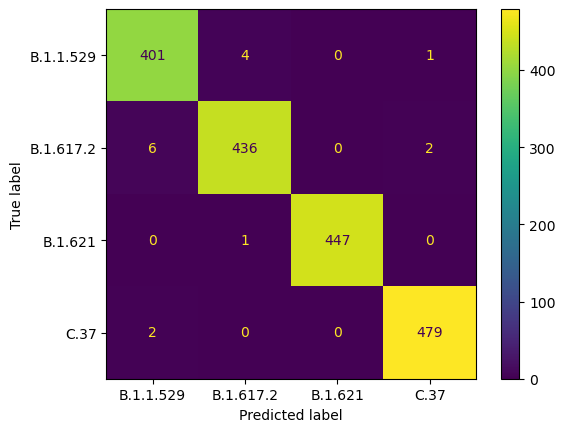

Confusion matrix for Quantized Plaintext: 


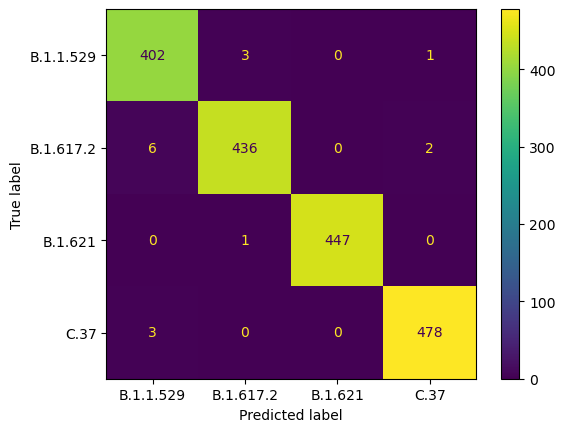

Confusion matrix for FHE: 


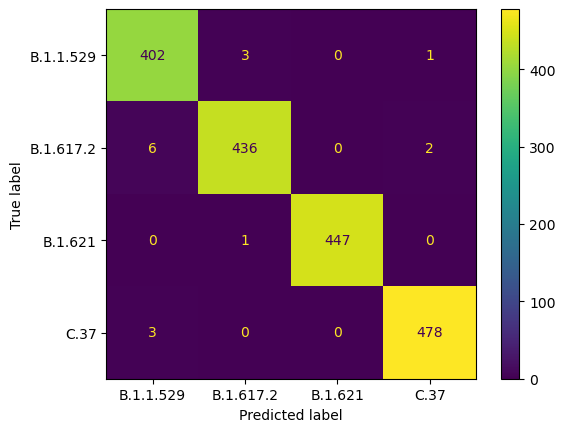

Running time is 3.737805128097534 seconds
Comparison (FHE vs Plaintext): 99% similar
Comparison (FHE vs Quantized Plaintext): 100% similar


In [14]:
# In[10]:
start_time = time.time()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("***Note: The diagonal elements are the correctly predicted samples. ***")

#use the scikit-learn classes because we use the same class naman
X_train, X_test, y_train, y_test = split(x,y)

print("Confusion matrix for SKLearn Plaintext: ")
#print(confusion_matrix(y_test, y_pred_sklearn), "\n")
skmodel = skLR(C=1)
skmodel.fit(X_train,y_train)
y_pred_sklearn = skmodel.predict(X_test)
sklearn_cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_sklearn), display_labels=le.classes_)
sklearn_cm_display.plot()
plt.show()

print("Confusion matrix for Quantized Plaintext: ")
#print(confusion_matrix(y_test, y_pred_clear), "\n")
model = LogisticRegression(C=1)
model.fit(X_train,y_train)
y_pred_clear = model.predict(X_test)
concrete_plain_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_clear), display_labels=le.classes_)
concrete_plain_display.plot()
plt.show()

print("Confusion matrix for FHE: ")
#print(confusion_matrix(y_test, y_pred_fhe))
model.compile(x)
y_pred_fhe = model.predict(X_test)
concrete_fhe_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_fhe), display_labels=le.classes_)
concrete_fhe_display.plot()
plt.show()

print(f"Running time is {time.time() - start_time} seconds")

print(f"Comparison (FHE vs Plaintext): {int((y_pred_fhe == y_pred_sklearn).sum()/len(y_pred_fhe)*100)}% similar")
print(f"Comparison (FHE vs Quantized Plaintext): {int((y_pred_fhe == y_pred_clear).sum()/len(y_pred_fhe)*100)}% similar")

In [7]:
from concrete.ml.sklearn.svm import LinearSVC
from sklearn.svm import LinearSVC as skSVC
from concrete.ml.sklearn.rf import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier as skRF

print(f"Sklearn Accuracy (Linear Reg, RF, SVC):")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)

    #SKLEARN LINEAR REGRESSION
    skmodel2 = skLinear()
    skmodel2.fit(X_train,y_train)
    skmodel2.predict(X_test)
    #print("Sklearn Linear Regression Accuracy: ", skmodel2.score(X_test,y_test)*100,"%")

    #SKLEARN RANDOM FOREST
    skmodel3 = skRF()
    skmodel3.fit(X_train, y_train)
    skmodel3.predict(X_test)
    #print("Sklearn Random Forest Accuracy: ",skmodel3.score(X_test,y_test)*100,"%")

    #SKLEARN SVC
    skmodel4 = skSVC()
    skmodel4.fit(X_train, y_train)
    skmodel4.predict(X_test)
    #print("Sklearn SVC Accuracy: ",skmodel4.score(X_test,y_test)*100,"%")

    print(f"{skmodel2.score(X_test,y_test)*100} {skmodel3.score(X_test,y_test)*100} {skmodel4.score(X_test,y_test)*100}")

print(f"Concrete-ML Accuracy (Linear Reg, RF, SVC):")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model2 = LinearRegression()
    model2.fit(X_train,y_train)
    model2.predict(X_test)
    #print("Concrete-ML Linear Regression Accuracy: ", model2.score(X_test,y_test)*100,"%")

    model3 = RandomForestClassifier()
    model3.fit(X_train, y_train)
    model3.predict(X_test)
    #print("Concrete-ML Random Forest Accuracy: ",model3.score(X_test,y_test)*100,"%")

    model4 = LinearSVC()
    model4.fit(X_train, y_train)
    model4.predict(X_test)
    #print("Concrete-ML SVC Accuracy: ",model4.score(X_test,y_test)*100,"%")

    print(f"{model2.score(X_test,y_test)*100}   {model3.score(X_test,y_test)*100}   {model4.score(X_test,y_test)*100}")

print(f"Concrete-ML FHE Accuracy (Linear Reg, RF, SVC):")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model2 = LinearRegression()
    model2.fit(X_train,y_train)
    model2.compile(x)
    model2.predict(X_test)
    #print("Concrete-ML Linear Regression Accuracy: ", model2.score(X_test,y_test)*100,"%")

    model3 = RandomForestClassifier()
    model3.fit(X_train, y_train)
    model3.compile(x)
    model3.predict(X_test)
    #print("Concrete-ML Random Forest Accuracy: ",model3.score(X_test,y_test)*100,"%")

    model4 = LinearSVC()
    model4.fit(X_train, y_train)
    model4.compile(x)
    model4.predict(X_test)
    #print("Concrete-ML SVC Accuracy: ",model4.score(X_test,y_test)*100,"%")

    print(f"{model2.score(X_test,y_test)*100}   {model3.score(X_test,y_test)*100}   {model4.score(X_test,y_test)*100}")

Sklearn Accuracy (Linear Reg, RF, SVC):
96.65275290104387 98.8195615514334 98.8195615514334
96.02998037964412 98.65092748735245 98.4822934232715
96.13986452091505 98.87577290612704 98.8195615514334
95.93590347297685 98.5947161326588 98.4822934232715
95.77052026625887 98.87577290612704 98.87577290612704
96.43415307252114 99.04440697020797 99.04440697020797
95.57847076543857 98.65092748735245 97.80775716694772
95.6985458293185 98.42608206857786 98.08881394041596
95.5971441802782 98.3698707138842 98.08881394041596
95.40405129316441 98.8195615514334 98.4822934232715
Concrete-ML Accuracy (Linear Reg, RF, SVC):
95.99780371736642   97.97639123102867   97.97639123102867
95.8429237819017   97.92017987633503   98.53850477796516
95.70196910587148   98.03260258572232   98.65092748735245
95.90996329379394   98.08881394041596   98.4822934232715
95.34991792745618   97.80775716694772   98.3698707138842
95.88706539117429   97.75154581225407   98.8195615514334
96.20347805179405   98.08881394041596   98.

In [6]:
#testing 10 runs to see the average compilation time of the FHE model
fhe_compile_results = []

print("Getting compilation metrics in seconds for Concrete-ML model (FHE)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    # Fit the model
    model.fit(X_train, y_train)
    #print("Compiling...")

    start_time = time.time()
    model.compile(x)
    fhe_compile_results.append(f"{time.time()-start_time}")

for r in fhe_compile_results:
    print(f"{r}")

Getting performance metrics for Concrete-ML model (FHE)...
2.047241449356079
2.0266034603118896
1.970088005065918
2.0242104530334473
1.9397697448730469
2.0181257724761963
2.008958339691162
2.0485622882843018
2.002124786376953
1.998833179473877


In [6]:
# In[10]:


#Attempting to save the model
from concrete.ml.deployment import FHEModelClient, FHEModelDev, FHEModelServer

start_time = time.time()

# fhemodel_dev = FHEModelDev("./concrete-covid-classifier", model)
# fhemodel_dev.save()

print(f"Running time for saving the FHE model is {time.time() - start_time} seconds")

start_time = time.time()

numpy.save('classes.npy', le.classes_)

print(f"Running time for saving the LabelEncoder classes is {time.time() - start_time} seconds")

Running time for saving the FHE model is 2.2411346435546875e-05 seconds
Running time for saving the LabelEncoder classes is 0.001401662826538086 seconds


In [ ]:
#Saving Scikit-learn model
from joblib import dump, load

dump(skmodel, './scikit-learn-classifier/scikitlearnmodel.joblib')
#loaded_model = load('scikitlearnmodel.joblib')

In [6]:
#trying condition numbers
import numpy as np

X_train, X_test, y_train, y_test = split(x,y)

skmodel = skLR(C=1)
skmodel.fit(X_train,y_train)
sklearn_condition = np.linalg.cond(skmodel.predict_proba(X_test))

model = LogisticRegression(C=1)
model.fit(X_train, y_train)
quant_condition = np.linalg.cond(model.predict_proba(X_test))

model.compile(x)
fhe_condition = np.linalg.cond(model.predict_proba(X_test))

print(f"Condition number of scikit-learn model:\n{sklearn_condition}")
print(f"Condition number of quantized model:\n{quant_condition}")
print(f"Condition number of FHE model:\n{fhe_condition}")

Condition number of scikit-learn model:
1.105945502735097
Condition number of quantized model:
1.105440477537656
Condition number of FHE model:
1.105440477537656
